# Scattering sequential model
* based upon: https://www.kymat.io/gallery_1d/plot_classif_torch.html#sphx-glr-gallery-1d-plot-classif-torch-py

* This implementation focus on a channel based implementation, keeping the original shape (num_measurements, 5000, 12) 
* now also keeping the original scattering result without calculating the mean

In [113]:
import scipy.io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.model_selection import train_test_split
from utilities.utils import CustomDataset
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

In [114]:
import utilities.data_loader as data_loader
import utilities.filter_data as filter_data
import importlib
importlib.reload(data_loader)
importlib.reload(filter_data)

<module 'utilities.filter_data' from '/mnt/c/Users/phil/university/verona/visual-intelligence-ecg-project/utilities/filter_data.py'>

## Loading Data

In [115]:
data_path = "data/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/a-large-scale-12-lead-electrocardiogram-database-for-arrhythmia-study-1.0.0/"
ecg_data_path = data_path + "WFDBRecords/"

In [116]:
importlib.reload(data_loader)
# data = data_loader.load_number_of_random_samples(ecg_data_path, 1000)
data = data_loader.load_number_of_random_samples_balanced(ecg_data_path, 750)

Loaded 750 of 750


In [117]:
healty_samples = [entry for entry in data if entry['binary_label'] == 0]
unhealty_samples = [entry for entry in data if entry['binary_label'] == 1]
print(f"Number of healty samples: {len(healty_samples)}")
print(f"Number of unhealty samples: {len(unhealty_samples)}")

Number of healty samples: 375
Number of unhealty samples: 375


In [118]:
# count how many nan in X
X = np.array([entry['data'] for entry in data], dtype=np.float32)
print(np.isnan(X).sum())

2


In [119]:
X = np.nan_to_num(X)
y = np.array([entry['binary_label'] for entry in data], dtype=np.float32)
print(np.isnan(y).sum())
print(X.shape)
print(y.shape)

0
(750, 5000, 12)
(750,)


In [120]:
# make sure no nan values
if np.isnan(X).any():
    print("!!!X contains NaN!!!")
else:
    print("X does not contain NaN")

X does not contain NaN


## Filtering Data

In [121]:
# remove baseline wander using DWT
for index in range(X.shape[0]):
    if index % 10 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing baseline wander sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_dwt_to_eliminate_baseline_wander(X[index, :, channel], hard_threshold=True)
        # X[index, :, channel] = filter_data.fir_filter_to_eliminate_baseline_wander(X[index, :, channel])  # to slow...
print("Count nan: ", np.isnan(X).sum())

Removing baseline wander sample 750/750
Count nan:  0


In [122]:
# remove power line interference using notch filter
for index in range(X.shape[0]):
    if index % 50 == 0 or index == X.shape[0] - 1:
        clear_output(wait=True)
        print(f"Removing power line interference sample {index + 1}/{X.shape[0]}")
    for channel in range(X.shape[2]):
        X[index, :, channel] = filter_data.apply_notch_filter(X[index, :, channel])
print("Count nan: ", np.isnan(X).sum())

Removing power line interference sample 750/750
Count nan:  0


In [123]:
# TODO: some issues with infinity, fix...
# remove EMG noise and electrode motion artifacts using adaptive filter
# for index in range(X.shape[0]):
#     if index % 20 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Removing EMG noise sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_adaptive_filter(X[index, :, channel])

In [124]:
# TODO: read this!!! https://www.researchgate.net/publication/347930656_Comparative_Study_on_the_Effect_of_Order_and_Cut_off_Frequency_of_Butterworth_Low_Pass_Filter_for_Removal_of_Noise_in_ECG_Signal
# cutoff_frequency = 50  # TODO: find good value
# for index in range(X.shape[0]):
#     if index % 50 == 0 or index == X.shape[0] - 1:
#         clear_output(wait=True)
#         print(f"Filtering sample {index + 1}/{X.shape[0]}")
#     for channel in range(X.shape[2]):
#         X[index, :, channel] = filter_data.apply_low_pass_filter(X[index, :, channel], cutoff_frequency)

In [125]:
# TODO: implement LOESS filter?!

In [126]:
print(np.isnan(X).sum())

0


## Data into dataset

In [127]:
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1905)

# make sure mean zero and unit variance
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
# X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# scale each channel on its own:
for channel in range(X_train.shape[2]):
    scaler = StandardScaler()
    X_train[:,:,channel] = scaler.fit_transform(X_train[:,:,channel])
    X_test[:,:,channel] = scaler.transform(X_test[:,:,channel])

print(X_train.shape)

(600, 5000, 12)


## Model

In [128]:
import torch
from torch.nn import Linear, NLLLoss, LogSoftmax, Sequential
from torch.optim import Adam
from sklearn.metrics import confusion_matrix
from kymatio.torch import Scattering1D
from kymatio.datasets import fetch_fsdd

In [129]:
# TODO: implement cuda!
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(1905)
if use_cuda:
    print("Using GPU")

Using GPU


In [130]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_train[0, :, 7])
plt.subplot(1,2,2)
plt.plot(X_train[1, :, 7])
plt.show()

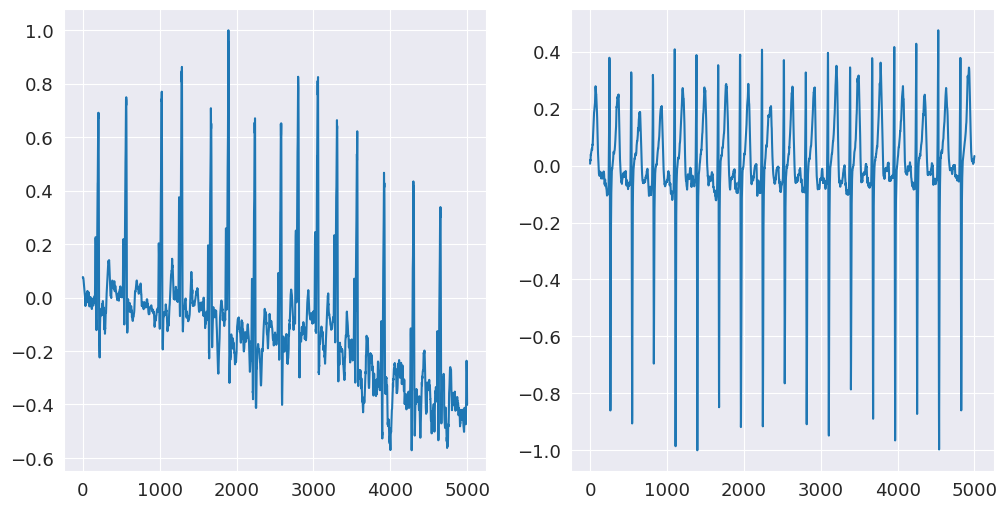

In [131]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(X_train[0, :, 7] / np.max(np.abs(X_train[0, :, 7])))
plt.subplot(1,2,2)
plt.plot(X_train[1, :, 7] / np.max(np.abs(X_train[1, :, 7])))
plt.show()

In [132]:
print(X_train.shape)

(600, 5000, 12)


In [232]:
T = X_train.shape[1]
J = 8
Q = 8
log_eps = 1e-6
# scattering = Scattering1D(J, T, Q).to(device)
# scattering = Scattering1D(J, shape=X_train.shape[1], T=T, Q=Q).to(device)
scattering = Scattering1D(J, shape=X_train.shape[1], Q=Q).to(device)

In [233]:
scattering_apply_log = True
scattering_normalize = True
scatering_use_mean = True
scattering_standardscale_result = True

### Train set

In [234]:
# TODO: move scattering into nn module class
scattering_results_np = []
standard_scaler_per_channel = []
for channel in range(X_train.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_train.shape[2]}")
    
    value = np.ascontiguousarray(X_train[:, :, channel])
    # normalize value
    if scattering_normalize:
        value /= np.max(np.abs(value))
    
    scattering_result = scattering.forward(torch.from_numpy(value).to(device))
    scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    # for preventing small values
    if scattering_apply_log:
        scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    if scatering_use_mean:
        scattering_result = torch.mean(scattering_result, dim=-1)
    scattering_result = torch.Tensor.cpu(scattering_result)
    
    
    # standard scaler
    # TODO: is this required? kinda weird, scaling data here again results in train accuracy of 1.0, kinda overfitting. Without scaling, train accuracy is below 0.7 but increases very slowly, no strong overfitting.
    # probably dont use for now?
    # TODO: still not sure...
    if scattering_standardscale_result:
        scaler = StandardScaler()
        scattering_result = scaler.fit_transform(scattering_result)
        standard_scaler_per_channel.append(scaler)
    
    scattering_results_np.append(scattering_result)

Scattering channel 12/12


In [235]:
scattering_results_np = np.array(scattering_results_np)
print(scattering_results_np.shape)

(12, 600, 233)


In [236]:
scattering_results_np = scattering_results_np.reshape(scattering_results_np.shape[1], scattering_results_np.shape[0], scattering_results_np.shape[2])
print(scattering_results_np.shape)
if np.isnan(scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

(600, 12, 233)
Scattering results does not contain NaN


### Test set

In [237]:
print(X_test.shape)

(150, 5000, 12)


In [238]:
test_scattering_results_np = []
for channel in range(X_test.shape[2]):
    clear_output(wait=True)
    print(f"Scattering channel {channel + 1}/{X_test.shape[2]}")
    
    value = np.ascontiguousarray(X_test[:, :, channel])
    # normalize value
    if scattering_normalize:
        value /= np.max(np.abs(value))
    
    scattering_result = scattering.forward(torch.from_numpy(value).to(device))
    scattering_result = scattering_result[:, 1:,:]  # remove zeroth order scattering coefficients
    scattering_result = scattering_result.double()
    
    
    if scattering_apply_log:
        scattering_result = torch.log(torch.abs(scattering_result) + log_eps)
    if scatering_use_mean:
        scattering_result = torch.mean(scattering_result, dim=-1)
    scattering_result = torch.Tensor.cpu(scattering_result)
    
    # only scale if train data was also scaled
    if standard_scaler_per_channel is not None and len(standard_scaler_per_channel) > 0:
        scattering_result = standard_scaler_per_channel[channel].transform(scattering_result)
    
    test_scattering_results_np.append(scattering_result)

test_scattering_results_np = np.array(test_scattering_results_np)

test_scattering_results_np = test_scattering_results_np.reshape(test_scattering_results_np.shape[1], test_scattering_results_np.shape[0], test_scattering_results_np.shape[2])
print(test_scattering_results_np.shape)
if np.isnan(test_scattering_results_np).any():
    print("!!!Scattering results contains NaN!!!")
else:
    print("Scattering results does not contain NaN")

Scattering channel 12/12
(150, 12, 233)
Scattering results does not contain NaN


In [239]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(scattering_results_np[0, 7, :])
plt.subplot(1,2,2)
plt.plot(scattering_results_np[2, 7, :])
plt.show()

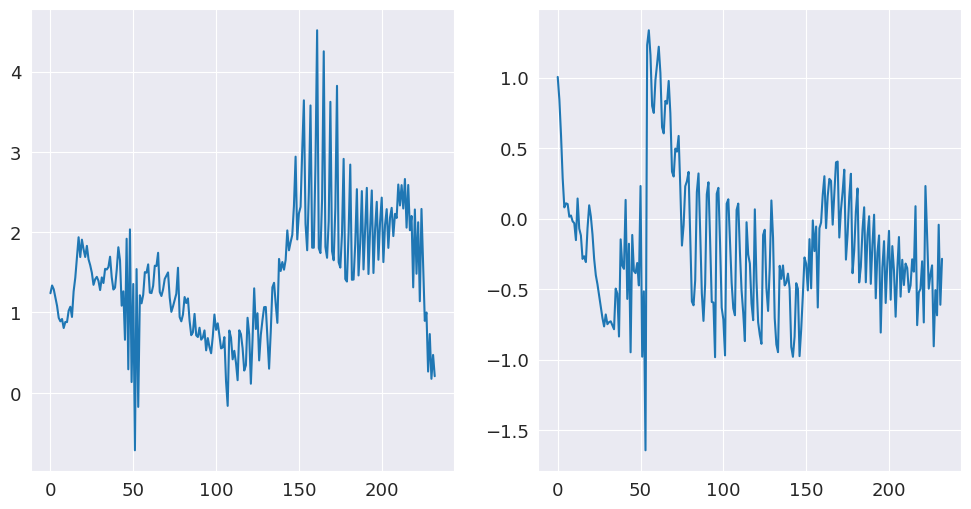

In [240]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(test_scattering_results_np[0, 7, :])
plt.subplot(1,2,2)
plt.plot(test_scattering_results_np[2, 7, :])
plt.show()

In [241]:
print(test_scattering_results_np.shape)

(150, 12, 233)


In [242]:
# scattering_results_np
# test_scattering_results_np

In [243]:
# TODO: reshape to only use one timeseries -> channel 3
scattering_results = scattering_results_np[:, 3, :].reshape(scattering_results_np.shape[0], scattering_results_np.shape[2])

test_scattering_results = test_scattering_results_np[:, 3, :].reshape(test_scattering_results_np.shape[0], test_scattering_results_np.shape[2])
print(scattering_results.shape)
print(test_scattering_results.shape)

(600, 233)
(150, 233)


In [244]:
# test_scattering_results = np.abs(test_scattering_results)
# scattering_results = np.abs(scattering_results)

In [245]:
from keras.models import Sequential
from keras.layers import LSTM, Activation, Dropout, Dense, BatchNormalization, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.regularizers import L2
import keras
import tensorflow as tf

In [246]:
series_length = scattering_results.shape[1]
num_classes = 2

In [247]:
# Number of signals to use in each gradient descent step (batch).
batch_size = 16
# Number of epochs.
num_epochs = 200

In [248]:
nsamples = scattering_results.shape[0]
nbatches = nsamples // batch_size

print("nsamples: ", nsamples)
print("nbatches: ", nbatches)
print("series_length: ", series_length)
print("num_classes: ", num_classes)

nsamples:  600
nbatches:  37
series_length:  233
num_classes:  2


In [249]:
model = Sequential()
# model.add(LSTM(128, input_shape=(series_length, 1), return_sequences=True))
# model.add(LSTM(128, return_sequences=False))
model.add(BatchNormalization(input_shape=(series_length,)))
model.add(Dense(64, input_shape=(series_length,), activation='relu'))
model.add(Dropout(0.2))
# model.add(Dense(256, activation='relu'))
# model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(num_classes, activation='sigmoid'))

In [250]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [251]:
# model.summary()

In [252]:
# hot encode
y_train_he = keras.utils.to_categorical(y_train, num_classes)
y_test_he = keras.utils.to_categorical(y_test, num_classes)

In [253]:
print(scattering_results.shape)
print(y_train_he.shape)
print(test_scattering_results.shape)
print(y_test_he.shape)

(600, 233)
(600, 2)
(150, 233)
(150, 2)


In [254]:
model.fit(x=scattering_results, y=y_train_he, epochs=num_epochs, batch_size=batch_size, validation_data=(test_scattering_results, y_test_he))

Epoch 1/200
38/38 [==============================] - 1s 8ms/step - loss: 0.7224 - accuracy: 0.5317 - val_loss: 0.7091 - val_accuracy: 0.5133
Epoch 2/200
38/38 [==============================] - 0s 6ms/step - loss: 0.7017 - accuracy: 0.5533 - val_loss: 0.7148 - val_accuracy: 0.4933
Epoch 3/200
38/38 [==============================] - 0s 6ms/step - loss: 0.6912 - accuracy: 0.5600 - val_loss: 0.7131 - val_accuracy: 0.4867
Epoch 4/200
38/38 [==============================] - 0s 6ms/step - loss: 0.6788 - accuracy: 0.5900 - val_loss: 0.7160 - val_accuracy: 0.4933
Epoch 5/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6847 - accuracy: 0.5983 - val_loss: 0.7373 - val_accuracy: 0.5133
Epoch 6/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6724 - accuracy: 0.6050 - val_loss: 0.7352 - val_accuracy: 0.5000
Epoch 7/200
38/38 [==============================] - 0s 7ms/step - loss: 0.6557 - accuracy: 0.6233 - val_loss: 0.7309 - val_accuracy: 0.4800
Epoch 8/200
3

In [255]:
len(scattering_results)

600